In [9]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
!pip install cftime
!pip install utils
!pip install netCDF4 
!pip install scipy
!pip install "xarray[io]"
#https://github.com/taliaa21/surface_water_hydrology/blob/main/time_series_SST.ipynb

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4 as nc4

In [ ]:

#ds = xr.open_dataset('mock.nc', decode_times=False)
ds = xr.open_dataset('mock1.nc')
df = ds.to_dataframe()

df

#data5['time']

In [8]:

del df_train['sp']
del df_train['u10']
del df_train['sshf']
del df_train['slhf']
del df_train['v10']
del df_train['sst']


In [7]:
del df_test['sp']
del df_test['u10']
del df_test['sshf']
del df_test['slhf']
del df_test['v10']
del df_test['sst']

In [5]:
# Convert to dataframe
df_train = ds.sel(time=slice('2021-01-01','2021-10-01')).to_dataframe().reset_index()
# Fill nan values of SST with zero
df_train.loc[:, 't2m'] = df_train.loc[:, 't2m'].fillna(0)
df_train.loc[:, 't2m'] = df_train.loc[:, 't2m']

In [ ]:
# Convert to dataframe
df_test = ds.sel(time=slice('2021-10-02','2021-12-31')).to_dataframe().reset_index()
# Fill nan values of SST with zero
df_test.loc[:, 't2m'] = df_test.loc[:, 't2m'].fillna(0)
df_test.loc[:, 't2m'] = df_test.loc[:, 't2m']
df_test

In [ ]:
df_test

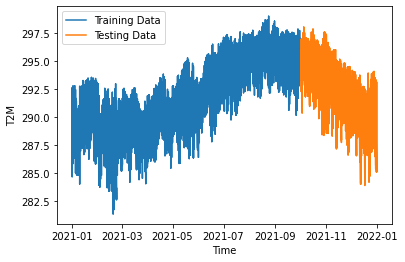

In [7]:
plt.plot(df_train['time'], df_train['t2m'], label = 'Training Data')
plt.plot(df_test['time'], df_test['t2m'], label = 'Testing Data')
plt.xlabel('Time')
plt.ylabel('T2M')
plt.legend();

In [ ]:
plt.plot(df_test.loc[1:10000, 'sst'])

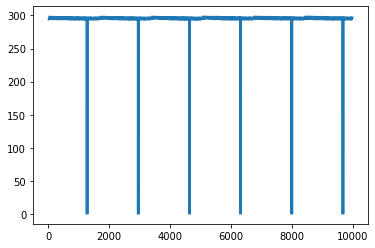

In [91]:
plt.plot(df_test.loc[1:10000, 'sst'])

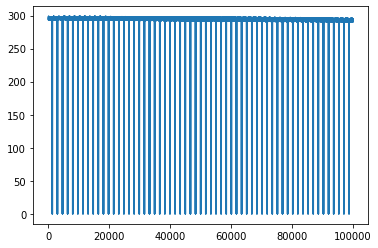

In [84]:
plt.plot( df_test.loc[1:100000, 'sst'])

In [8]:
# Import model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


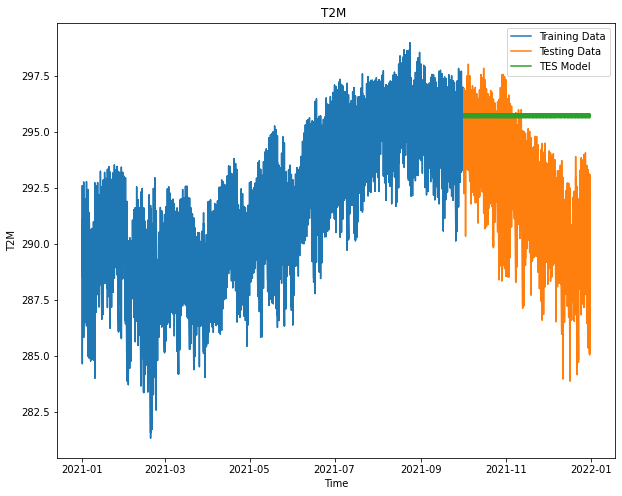

In [9]:
# Initialize triple exponential smoothing model
tes_model = ExponentialSmoothing(df_train.t2m, trend = None, seasonal = 'add', seasonal_periods = 52)
# Fit model
tes_fit = tes_model.fit(optimized = True)
# Forecast for 2007-2017
tes_pred = tes_fit.forecast(len(df_test.t2m)).reset_index(drop=True)
# Plot model
plt.figure(figsize=(10, 8))
plt.plot(df_train.time, df_train.t2m, label = 'Training Data')
plt.plot(df_test.time, df_test.t2m, label = 'Testing Data')
plt.plot(df_test.time, tes_pred, label = 'TES Model')
plt.xlabel('Time')
plt.ylabel('T2M')
plt.title('T2M ')
plt.legend();

In [ ]:
#Seasonal Autoregressive Integrated Moving Average (SARIMA) Model
# Import model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Initialize triple exponential smoothing model
sarima_model = SARIMAX(df_train.t2m, order=(1,1,1), seasonal_order=(1,1,1,52))
# Fit model
sarima_fit = sarima_model.fit()
# Forecast for 2007-2017
sarima_pred = sarima_fit.forecast(len(df_test.t2m)).reset_index(drop=True)
# Plot model
plt.figure(figsize=(8, 6))
plt.plot(df_train.time, df_train.sst, label = 'Training Data')
plt.plot(df_test.time, df_test.sst, label = 'Testing Data')
plt.plot(df_test.time, sarima_pred, label = 'SARIMA Model')
plt.xlabel('Time')
plt.ylabel('T2M')
plt.title('T2M')
plt.legend();

In [10]:
# Import model
from fbprophet import Prophet
# Prophet requires the time series to be a 2 column pd.dataframe with the Date as 'ds' and the values as 'y'.
df_prohpet = df_train.rename(columns = {'time':'ds', 't2m':'y'})
# Initialize Prophet model
prophet_model = Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=False, growth='flat')
# Fit the model on the time series
prophet_model.fit(df_prohpet)

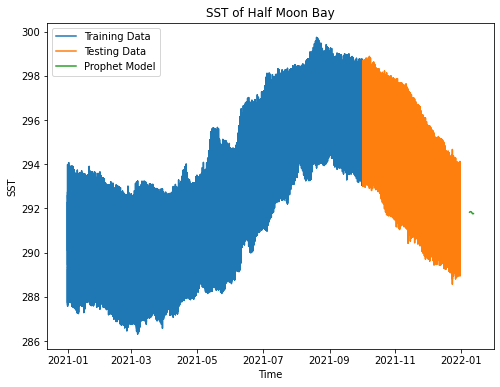

In [31]:
# Create a DataFrame of future dates to create forecasts for
prophet_pred_time = prophet_model.make_future_dataframe(periods=len(df_test.sst), freq = '2S', include_history = False) + pd.DateOffset(days=100)
# Use the model to create forecasts
prophet_pred = prophet_model.predict(prophet_pred_time)
# Plot model
plt.figure(figsize=(8, 6))
plt.plot(df_train.time, df_train.sst, label = 'Training Data')
plt.plot(df_test.time, df_test.sst, label = 'Testing Data')
plt.plot(prophet_pred.ds, prophet_pred.yhat, label = 'Prophet Model')
plt.xlabel('Time')
plt.ylabel('SST')
plt.title('SST of Half Moon Bay')
plt.legend();

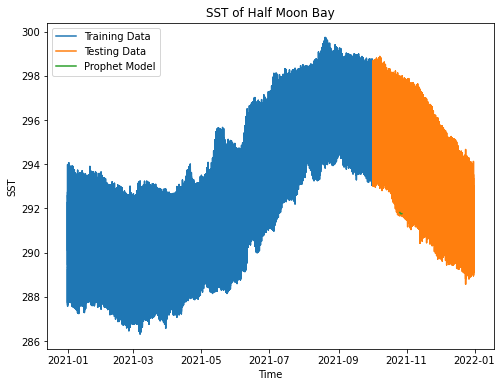

In [17]:
# Create a DataFrame of future dates to create forecasts for
future = prophet_pred_time + pd.DateOffset(days=10)
# Use the model to create forecasts
prophet_pred_future = prophet_model.predict(future)
# Plot model
plt.figure(figsize=(8, 6))
plt.plot(df_train.time, df_train.sst, label = 'Training Data')
plt.plot(df_test.time, df_test.sst, label = 'Testing Data')
plt.plot(prophet_pred_future.ds, prophet_pred_future.yhat, label = 'Prophet Model')
plt.xlabel('Time')
plt.ylabel('SST')
plt.title('SST of Half Moon Bay')
plt.legend();


In [18]:
# Import metrics functions
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error

# Define MAPE function
def mape(actual, pred):
    mape = np.mean(np.abs((actual - pred)/actual))*100
    return mape

# Metrics function
def metrics(actual, pred, model_name):
  print('------', model_name, ' Model------')
  print("R2: ", np.round(r2_score(actual, pred), 4))
  print("MAE: ", np.round(mean_absolute_error(actual, pred), 4))
  print("MAPE: ", np.round(mape(actual, pred), 4))
  print("MSE: ", np.round(mean_squared_error(actual, pred), 4))

In [19]:
# Metrics of TES Model
metrics(df_test.sst, tes_pred, 'TES')

------ TES  Model------


ValueError: ignored

In [ ]:
# Metrics of Prophet Model
metrics(df_test.sst, prophet_pred.yhat, 'Prophet')